#Data Explorer 02
##Mark Holt

In [1]:
from IPython import display
import numpy as np
import pandas as pd
import string
import re
import sys
import traceback
from matplotlib import pyplot as plt
%matplotlib inline
from sets import Set
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

####Define some functions that might be useful
####I developed these functions while I explored the data, I did NOT end up using them all

In [2]:
def perDiff(a, b):
    '''A simple word comparator function. Traverses along 2 words and compares the letters, returning the number of differences'''
    sameCount = 0
    diffCount = 0
    aL = len(a)
    bL = len(b)
    
    if aL > bL:
        diffCount = aL - bL
        n = bL
    else:
        diffCount = bL - aL
        n = aL
        
    #iterate over the shortest word
    for i in xrange(n):
        if a[i] == b[i]:
            sameCount = sameCount + 1
        else:
            diffCount = diffCount + 1
    return(diffCount)

def wordDiff(a, b):
    '''Utilizing perDiff above this function takes in 2 sentences and compares them on a word by word basis'''
    diffCount = 0
    
    #split up the sentences
    s1 = a.split(' ')
    s2 = b.split(' ')
    
    aS = len(s1)
    bS = len(s2)      
    
    if aS > bS:
        diffCount = 10 * (aS - bS)
        nn = bS
    else:
        diffCount = 10 * (bS - aS)
        nn = aS
    
    #iterate over the shortest sentence
    for i in xrange(nn):
            #if the words are not the same the diffCount them
            if(s1[i]!=s2[i]):
                diffCount = diffCount + perDiff(s1[i], s2[i])
    return diffCount

def compDiffWords(lcCols):
    '''This function utilizes wordDiff to compare a list of sentences with each other. 
    Each sentence is compared to every other sentence.
    
    If the sentences are different, but only by 2, then the pair of sentences is added to a list
    
    The list of close sentence pairs is returned'''
    colar = []
    for i in xrange(len(lcCols)):
        for j in xrange(len(lcCols)):
            if(i != j):
                nn = wordDiff(lcCols[i],lcCols[j])
                if nn < 2:
                    if(i<j):
                        b=(i,j)
                    else:
                        b=(j,i)
                    if(b in colar):
                        k=0
                    else:
                        colar.append(b)
    return colar

def merge_two_cols(df, c1, c2, nrows):
    '''This merges 2 columns by taking the average value of the 2 columns and using that for the value of the merged column'''
    
    sumd = 0.0
    new_col = np.zeros(nrows, dtype =  np.float)
    for i in xrange(nrows):
        sumd = (df.iloc[i][c1] + df.iloc[i][c2])/2.0
        new_col[i] = sumd
    return new_col

def alter_names(songs):
    '''Converts song titles to lower case and then
    using the regular expression functionality do a replacement for wayward characters in song titles
    Operates on a list of song titles'''
    for i in xrange(len(songs)):
        songs[i] = songs[i].lower()
    
    pattern = r'[1-9\',.;!?#\[\]\>]*'
    for i in xrange(len(songs)):
        songs[i] = re.sub(pattern, '', songs[i])

    pattern = r'[\-\/]'
    for i in xrange(len(songs)):
        songs[i] = re.sub(pattern, ' ', songs[i])
    
    return songs

def alter_name(song):
    '''Same as alter_names, but this function works on a single song title'''
    song = song.lower()
    
    pattern = r'[1-9\',.;!?#\[\]\>]*'
    song = re.sub(pattern, '', song)

    pattern = r'[\-\/]'
    song = re.sub(pattern, ' ', song)
    
    return song


def p(songs1):
    '''A combining function utilizing the functions above. The aim is to process the song titles and present pairs of song titles
    that are close, to the user for reconciliation. 
    Splits up songs using an open bracket as a divider, then makes a list of unique songs
    Performs regular expression replacement, as per alter_songs, and then peforms a compDiffWords 
    calculation
    This function allows for interactive determination of which song title you would like to keep.'''
    songs2 = []
    for s in songs1:
        p = s.lower().split(" (")
        if p[0] not in songs2:
            songs2.append(p[0]) 
            
    pattern = r'[1-9\',.;!?#\[\]\>]*'
    for i in xrange(len(songs2)):
        songs2[i] = re.sub(pattern, '', songs2[i])

    pattern = r'[\-\/]'
    for i in xrange(len(songs2)):
        songs2[i] = re.sub(pattern, ' ', songs2[i])
        
        
    n=0
    while n != -1:
        i = compDiffWords(songs2)
        for j in i:
            print j[0], songs2[j[0]], j[1], songs2[j[1]]
        n = raw_input("Enter number to delete, or -1 to end")
        n = int(n)
        if n >= 0:
            del songs2[n]
        display.clear_output(wait=True)
    return songs2


def display_comp_diff(songlist):
    '''This function displays and invites the user to reconcile close song titles'''
    
    n=0
    while n != -1:
        i = compDiffWords(songlist)
        for j in i:
            print j[0], songlist[j[0]], j[1], songlist[j[1]]
        n = raw_input("Enter the number to delete, or -1 to end")
        n = int(n)
        if n >= 0:
            del songlist[n]
        display.clear_output(wait = True)
    return songlist

def do_ing(song_word):
    '''Adds ing to some song titles'''
    
    if len(song_word) > 3:
        if (song_word[-2:] == 'in') & (song_word[-3:]!='ain') & \
            (song_word[-3:] != ' in') & (song_word[-3:] != 'pin'):
            song_word = song_word + 'g'
    return song_word

def process_song_title(st):
    '''This function elimiates stray blanks in song titles
    It decomposes the title into words, elimiates all blanks and then recomposes the words back into a title'''
    
    bits = st
    ff = bits.split(' ')
    fflist = []
    
    #for each word in the song replace all occurrences of spaces
    for fff in ff:
        fff.replace(" ", "")
        fflist.append(fff)
    
    #now bolt the words back together with a single space in between
    p = ""
    for i in fflist:
        if i not in string.ascii_lowercase:
            i = do_ing(i)
            p += i + " "
    return p[:-1]
    #print p
    
def replace_ampersands(st):
    '''A simple function to replace an & with the word and'''
    
    st = st.replace('&', 'and')
    return st

#####read in the dataset

In [3]:
df = pd.read_csv("/Users/mrgholt/GADS-22-NYC/Datasets/GDsetlists.csv")

#####We have 1389 rows - comprising years
#####and 433 songs, although not all of them look like songs

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1389 entries, 0 to 1388
Columns: 433 entries, 26 Miles to year
dtypes: bool(432), int64(1)
memory usage: 607.7 KB


#####get the number of rows and define a new empty dataframe

In [5]:
#get the number of rows in the data frame
nrows = len(df[df.columns[0]])

#initialize a new data frame
new_df = pd.DataFrame()

#####Convert all columns to floats
#####We are going to merge columns where the song titles are the same (but are not due to typos)
#####When we merge we are going to take the average of the values, because there is some ambiguity in the dataset - 2 conflicting values

In [6]:
#convert all columns to floats
#make a new dataframe called new_df
for i in xrange(len(df.columns)):
    try:
        #put the transformed data into the new data frame
        new_df[df.columns[i]] = df[df.columns[i]].astype(float)
    except:
        #traceback.print_exc()
        print "couldn't convert column ", df.columns[i], " to float"

#####generate a list of 'close' song titles from the data frame columns
#####these are duplicate columns with close names, that are separated because of mispellings, etc

In [7]:
#use the compDiffWords function to evaluate the song titles

jlist = compDiffWords(new_df.columns.values)
for i in jlist:
    print "Column {:5d} is {:40s} column {:5d} is {:40s}".format(i[0], new_df.columns.values[i[0]], i[1], new_df.columns.values[i[1]])

Column     7 is All Along The Watchtower                 column     8 is All Along the Watchtower                
Column    29 is Big RIver                                column    31 is Big River                               
Column    44 is Box Of Rain                              column    45 is Box of Rain                             
Column    66 is Comes A Time                             column    67 is Comes a Time                            
Column   120 is Drums                                    column   429 is drums                                   
Column   130 is Fire On the Mountain                     column   131 is Fire on the Mountain                    
Column   146 is Goin' Down the Road Feelin' Bad          column   147 is Goin' Down the Road Feeling Bad         
Column   164 is Hell In a Bucket                         column   165 is Hell in a Bucket                        
Column   167 is Here Come Sunshine                       column   168 is Here Comes Suns

#####Define another new data frame

In [8]:
new_df2 = pd.DataFrame()

#####Using compDiffWords merge the two similar columns
#####Try to check the song title using alter_name before assigning it to be the columns header
#####Use the new data frame

In [9]:
count = 0
initialj = 0
mergedlist = []
new_column_names = []

#traverse the list and merge columns by taking the average of each column
for i in xrange(len(jlist)):
    print jlist[i]
    
    #m1 and m2 are the column numbers that need to be merged
    m1 = jlist[i][0]
    m2 = jlist[i][1]
    
    #we need to remember which columns we merge for the next cell
    mergedlist.append(m1)
    mergedlist.append(m2)
    
    #merge the two columns 
    alist = list(new_df[new_df.columns[m1]])
    blist = list(new_df[new_df.columns[m2]])

    #take the average value
    n = []
    for j in xrange(len(alist)):
        c = (alist[j] + blist[j])/2.0
        n.append(c)
    
    #assing merged column into a new data frame
    new_df2[alter_name(new_df.columns.values[m2])] = n
    count += 1

(7, 8)
(29, 31)
(44, 45)
(66, 67)
(120, 429)
(130, 131)
(146, 147)
(164, 165)
(167, 168)
(169, 170)
(187, 188)
(201, 202)
(203, 430)
(215, 217)
(225, 226)
(239, 240)
(242, 243)
(247, 248)
(260, 261)
(287, 288)
(291, 409)
(297, 298)
(303, 304)
(308, 349)
(314, 315)
(320, 321)
(324, 325)
(329, 330)
(332, 431)
(341, 342)
(346, 347)
(358, 359)
(369, 370)
(380, 382)
(387, 388)
(391, 393)
(401, 402)
(415, 416)


#####Check out the new data frame info

In [10]:
new_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1389 entries, 0 to 1388
Data columns (total 38 columns):
all along the watchtower          1389 non-null float64
big river                         1389 non-null float64
box of rain                       1389 non-null float64
comes a time                      1389 non-null float64
drums                             1389 non-null float64
fire on the mountain              1389 non-null float64
goin down the road feeling bad    1389 non-null float64
hell in a bucket                  1389 non-null float64
here comes sunshine               1389 non-null float64
hey bo diddley                    1389 non-null float64
im a man                          1389 non-null float64
jack straw                        1389 non-null float64
jam                               1389 non-null float64
let it grow                       1389 non-null float64
loose lucy                        1389 non-null float64
me & my uncle                     1389 non-null float

#####Copy the rest of the colummns into the new dataframe

In [11]:
for i in xrange(len(df.columns)):
    
    #now add the other columns into the new data frame
    if i not in mergedlist:
        try:
            new_df2[alter_name(df.columns[i])] = new_df[df.columns[i]]
        except:
            print "couldn't convert column ", new_df.columns[i], " to float"

#####Re-check the new data frame info

In [12]:
new_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1389 entries, 0 to 1388
Columns: 393 entries, all along the watchtower to year
dtypes: float64(393)
memory usage: 4.2 MB


#####Try to clean up the song titles a little more using process_song_title()

In [13]:
new_df2_song_titles = []
for col in new_df2.columns.values:
    s = process_song_title(col)
    new_df2_song_titles.append(s)
new_df2.columns = new_df2_song_titles

#####Hopefully compDiffWords returns an empty list - we should have handled all the similar song titles

In [14]:
compDiffWords(new_df2.columns)

[]

#####Fix by hand some of the other song duplicates that compDiffWords missed

In [15]:
mask = []
for i in new_df2.columns.values:
    m = 'uncle' in i
    mask.append(m)
print new_df2.iloc[0][mask]

me & my uncle            0
me and my uncle          0
uncle johns band         0
uncle johns bands jam    0
Name: 0, dtype: float64


#####By hand merger 'me & my uncle' and 'me and my uncle'

In [16]:
alist = new_df2['me & my uncle']
blist = new_df2['me and my uncle']
new_col = []
for i in xrange(len(alist)):
    c = (alist[i] + blist[i])/2.0
    new_col.append(c)
del new_df2['me & my uncle']
new_df2["me and my uncle"] = new_col

#####Continue to monitor the new_df2 data frame info

In [17]:
new_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1389 entries, 0 to 1388
Columns: 392 entries, all along the watchtower to year
dtypes: float64(392)
memory usage: 4.2 MB


#####What are the columns with the words "Comments" about?

In [18]:
mask = ['Comments' in name for name in df.columns.values]
df[df.columns[mask]].sum()

Comments: Baba Olatungi and Bela Fleck and the Flecktones Opened, Nationwide FM    1
Comments: Bill Graham Memorial Concert, FM Broadcast                               1
Comments: Bob and Jerry Acoustic                                                   1
Comments: Brent Mydland's First Show                                               1
Comments: Brent Mydland's Last Show.  Brent Died on 7/26, Three Days Later.        1
Comments: Carlos Santana and his band opened                                       2
Comments: Chinese New Year                                                         1
Comments: David Letterman                                                          1
Comments: Dwight Yoakam opened                                                     1
Comments: First Vince "AWBYGN"                                                     1
Comments: First Vince "Attics"                                                     1
Comments: Johnny Clegg and Savuka Opened                         

#####We can delete these?? The comments seem to only apply to a single concert in most cases
#####Probably should have used a new data frame here, but instead put the results back into new_df2

In [19]:
#look for the word 'Comments'
patternC = r'Comments'

#compile this into a regular expression, ignoring case
regex = re.compile(patternC, flags=re.IGNORECASE)

theCols = new_df2.columns
#work through the columns 1 at a time
for i in xrange(len(theCols)):
    
    #if you find an instance of 'Comments' in the column heading then drop the comment
    if(len(regex.findall(theCols[i]))>0):
        print "dropping ", theCols[i]
        new_df2 = new_df2.drop([theCols[i]], axis = 1)

dropping  comments: baba olatungi and bela fleck and the flecktones opened nationwide fm
dropping  comments: bill graham memorial concert fm broadcast
dropping  comments: bob and jerry acoustic
dropping  comments: brent mydlands first show
dropping  comments: brent mydlands last show brent died on three days later
dropping  comments: carlos santana and his band opened
dropping  comments: chinese new year
dropping  comments: david letterman
dropping  comments: dwight yoakam opened
dropping  comments: first vince "awbygn"
dropping  comments: first vince "attics"
dropping  comments: johnny clegg and savuka opened
dropping  comments: letterman
dropping  comments: little feat opened
dropping  comments: nuclear disarmament benefit
dropping  comments: rex foundation benefit
dropping  comments: santana opened
dropping  comments: sing out for sight
dropping  comments: summer solstice show
dropping  comments: teddy bear picnic before stranger
dropping  comments: vince welniks first show
dropping

#####Check the new_df2 info again

In [20]:
new_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1389 entries, 0 to 1388
Columns: 365 entries, all along the watchtower to year
dtypes: float64(365)
memory usage: 3.9 MB


In [21]:
def accuracy_report(clf, xtrain,ytrain,xtest, ytest):
    '''This function just reports classification accuracy on both the training and test sets'''
    
    print "Accuracy: %0.2f%%" % (100 * clf.score(xtest, ytest))

    #Print the accuracy on the test and training dataset
    training_accuracy = clf.score(xtrain, ytrain)
    test_accuracy = clf.score(xtest, ytest)

    print "Accuracy on training data: %0.2f" % (training_accuracy)

#####What's the balance of the data - i.e. how many playlists do we have for the 3 decades represented?

In [22]:
years = new_df.year.values
ylr = np.zeros((len(years), 1))
for i in xrange(len(new_df["year"])):
    if years[i] < 1980:
        #this is the 1970s
        ylr[i] = 0
    else:
        if years[i] < 1990:
            #this is the 1980s
            ylr[i] = 1
        else:
            #this is the 1990s
            ylr[i] = 2

#####Most playlists were performed in the 1980s

In [23]:
s0 = 0
s1 = 0
s2 = 0
for i in xrange(len(ylr)):
    if ylr[i] == 0:
        s0 += 1
    if ylr[i] == 1:
        s1 += 1
    if ylr[i] == 2:
        s2 += 1
print s0, s1, s2
print s0 + s1 + s2

462 722 205
1389


#####Nothing fancy on the prediction side
#####Use the, now, real-valued data in the data set to predict year
#####Use a logistic regression model
#####Input will be a vector of songs, not just a single song - this is quick and easy!
#####The predictor columns are all columns except year, which is the last column

In [24]:
predictor_cols = new_df2.columns.values[:-1]

#####Make the targets 0, 1, and 2 for the 3 decades
#####Straight forward logistic regression
#####This is using cross-validation - Do we need to really use this since there will be no 'new' data

In [25]:
reg=10000
X = new_df2[predictor_cols].values
print X.shape
y = ylr
y = ylr.reshape(-1)
print y.shape

sss = StratifiedShuffleSplit(y, 1, test_size=0.5, random_state=32)     
models = {}
count = 1

for train_index, test_index in sss:
    indexName = "LRmodel_" + str(count) 
 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
 
    clf_lr = LogisticRegression(C=reg).fit(X_train, y_train)
    print "LR-model_", count
    accuracy_report(clf_lr, X_train, y_train, X_test, y_test)
    models[indexName] = clf_lr
    count = count + 1
    
model_pick = models["LRmodel_1"]

(1389, 364)
(1389,)
LR-model_ 1
Accuracy: 90.07%
Accuracy on training data: 1.00


#####Cross validated results

In [26]:
pd.crosstab(y_test, model_pick.predict(X_test), rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0,2.0
Actual,,,
0,220,11,0
1,19,318,24
2,1,14,88


#####Train on all the data

In [27]:
reg=10000
X = new_df2[predictor_cols].values
print X.shape
y = ylr
y = ylr.reshape(-1)
print y.shape

models = {}
count = 22
indexName = "LRmodel_" + str(count) 
 
X_train = X
y_train = y    
 
clf_lr = LogisticRegression(C=reg).fit(X_train, y_train)
print "LR-model_", count
accuracy_report(clf_lr, X_train, y_train, X_train, y_train)
models[indexName] = clf_lr
    
model_pick = models["LRmodel_22"]

(1389, 364)
(1389,)
LR-model_ 22
Accuracy: 99.93%
Accuracy on training data: 1.00


In [28]:
pd.crosstab(y_train, model_pick.predict(X_train), rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0,2.0
Actual,,,
0,462,0,0
1,1,721,0
2,0,0,205


#####A routine that takes in a song and constructs the input vector by putting a 1 in the position for the song title, and filling the rest of the vector with 0s.
#####Is this really a valid thing to do???
#####You should account for the case of an unrecognized song!

In [29]:
def AnalyzeSong(song, clf, df):
    '''This function takes in a song and returns whether or not it was from the 1980s.
    It outputs the probabilities of belonging to each decade as well'''
    anArray = np.zeros(len(df.columns)-1)
    found = 0;
    
    #the song has to be a GD song in the first place
    #unlike submitting a playlist we are putting a single '1' in an empty array for a single song.
    for i in xrange(len(df.columns)):
        if song == df.columns[i]:
            found = 1
            anArray[i] = 1
    if found == 1:
        
        if (clf.predict(anArray) != 1):
            print "\""  + song + "\" is judged by clasifier to be..."
            print "Song not from the 1980s"
        else:
            print "\""  + song + "\" is judged by clasifier to be..."
            print "Song is from the 1980s"
            
        #print out the respective probabilities for belonging to each decade
        print "1970s={:5.3f}, 1980s={:5.3f}, 1990s={:5.3f}".format(clf.predict_proba(anArray).ravel()[0], \
                                                 clf.predict_proba(anArray).ravel()[1], \
                                                 clf.predict_proba(anArray).ravel()[2])
    else:
        print "Sorry this song is not recognized"
        
def AnalyzeSong1980(song, clf, df):
    '''This does the same as AnalyzeSong but is customized to print nicely when all the songs are input one after another'''
    anArray = np.zeros(len(df.columns)-1)
    found = 0;
    
    #the song has to be a GD song in the first place
    #unlike submitting a playlist we are putting a single '1' in an empty array for a single song.
    for i in xrange(len(df.columns)):
        if song == df.columns[i]:
            found = 1
            anArray[i] = 1
    if found == 1:
        
        if (clf.predict(anArray) == 1):
            print "\""  + song + "\" is judged by clasifier to be..."
            print "Song is from the 1980s"
            #print out the respective probabilities for belonging to each decade
            print "1970s={:5.3f}, 1980s={:5.3f}, 1990s={:5.3f}".format(clf.predict_proba(anArray).ravel()[0], \
                                                 clf.predict_proba(anArray).ravel()[1], \
                                                 clf.predict_proba(anArray).ravel()[2])
            print "\n--------------------------------------------\n"
    else:
        print "Sorry this song is not recognized"
    

#####Let's try some songs...

In [30]:
AnalyzeSong("wicked messenger", model_pick, new_df2)

"wicked messenger" is judged by clasifier to be...
Song not from the 1980s
1970s=1.000, 1980s=0.000, 1990s=0.000


In [31]:
AnalyzeSong("all along the watchtower", model_pick, new_df2)

"all along the watchtower" is judged by clasifier to be...
Song not from the 1980s
1970s=0.999, 1980s=0.000, 1990s=0.001


In [32]:
AnalyzeSong("althea", model_pick, new_df2)

"althea" is judged by clasifier to be...
Song is from the 1980s
1970s=0.497, 1980s=0.503, 1990s=0.000


In [33]:
AnalyzeSong("drums", model_pick, new_df2)

"drums" is judged by clasifier to be...
Song is from the 1980s
1970s=0.000, 1980s=0.500, 1990s=0.499


In [34]:
AnalyzeSong("sugaree", model_pick, new_df2)

"sugaree" is judged by clasifier to be...
Song not from the 1980s
1970s=1.000, 1980s=0.000, 1990s=0.000


In [35]:
AnalyzeSong("space", model_pick, new_df2)

"space" is judged by clasifier to be...
Song not from the 1980s
1970s=0.448, 1980s=0.000, 1990s=0.552


In [36]:
AnalyzeSong("bad moon rising", model_pick, new_df2)

"bad moon rising" is judged by clasifier to be...
Song not from the 1980s
1970s=0.999, 1980s=0.000, 1990s=0.001


In [37]:
AnalyzeSong("around and around", model_pick, new_df2)

"around and around" is judged by clasifier to be...
Song not from the 1980s
1970s=0.997, 1980s=0.000, 1990s=0.003


In [38]:
AnalyzeSong("big river", model_pick, new_df2)

"big river" is judged by clasifier to be...
Song not from the 1980s
1970s=1.000, 1980s=0.000, 1990s=0.000


In [39]:
for name in new_df2.columns.values:
    if name != 'year':
        AnalyzeSong1980(name, model_pick, new_df2)

"drums" is judged by clasifier to be...
Song is from the 1980s
1970s=0.000, 1980s=0.500, 1990s=0.499

--------------------------------------------

"going down the road feeling bad" is judged by clasifier to be...
Song is from the 1980s
1970s=0.302, 1980s=0.698, 1990s=0.000

--------------------------------------------

"let it grow" is judged by clasifier to be...
Song is from the 1980s
1970s=0.477, 1980s=0.523, 1990s=0.000

--------------------------------------------

"might as well" is judged by clasifier to be...
Song is from the 1980s
1970s=0.460, 1980s=0.540, 1990s=0.000

--------------------------------------------

"smokestack lightning" is judged by clasifier to be...
Song is from the 1980s
1970s=0.499, 1980s=0.501, 1990s=0.000

--------------------------------------------

"alabama getaway" is judged by clasifier to be...
Song is from the 1980s
1970s=0.300, 1980s=0.700, 1990s=0.000

--------------------------------------------

"althea" is judged by clasifier to be...
Song i

#Data Visualization

#####Perform a quick sanity check on new_df2
#####column totals match row totals

In [40]:
tt = new_df2[predictor_cols].sum(axis=1)

In [41]:
d = np.array(tt.values)
print d.sum()

23920.0


In [42]:
f = new_df2.sum(axis=0)[:-1]

In [43]:
d = np.array(f.values)
print d.sum()

23920.0


#####Let's produce a chart of all the songs that have been played more than 200 times
#####Pandas plotting really helps with the axes ticklabels

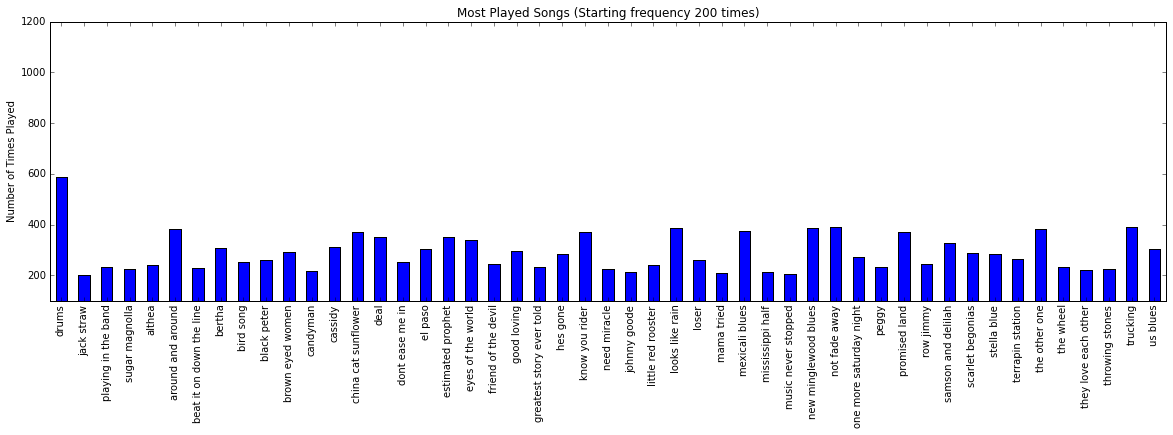

In [44]:
dff = new_df2.sum(axis=0)[:-1]
cutoff = 200
title = "Most Played Songs (Starting frequency {:d} times)".format(cutoff)
inds = dff.values > 200
dffDF = pd.DataFrame(dff[inds])
ax = dffDF.plot(kind="bar", figsize=(20,5), ylim=(100, 1200), title=title, legend=False)
ax.set_ylabel("Number of Times Played")

#####Let's plot a horizontal bar chart of the frequency of all the songs played
#####This also allows us to see how well we fixed up the song titles ... Hmmmm...it's not perfect by any means....

(0, 364)

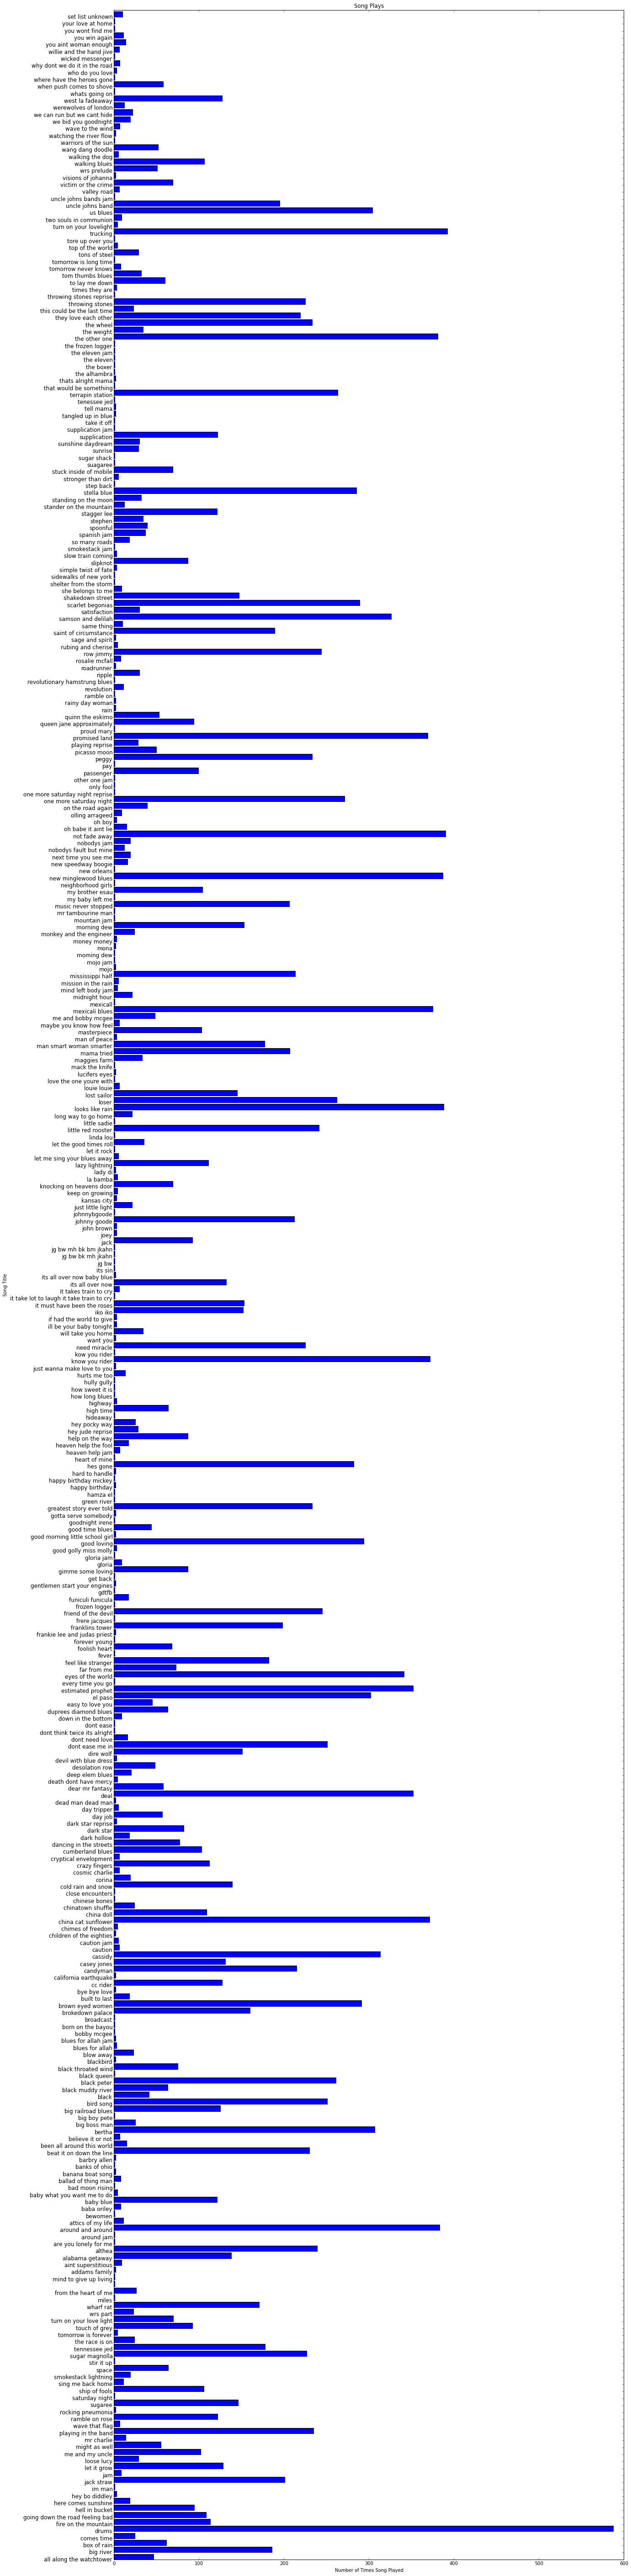

In [45]:
cols = new_df2.columns[:-1]
dffDF = new_df2[cols]

x_plot = list(xrange(len(dffDF.columns.values)))

fig = plt.figure(figsize=(20, 100))
ax = plt.subplot(111)
ax.barh(x_plot, dffDF.sum(axis = 0), color='blue') 
ax.set_yticks(list(x_plot))
ax.set_yticklabels(dffDF.columns.values, rotation=0, fontsize='large')
ax.set_title("Song Plays")
ax.set_xlabel("Number of Times Song Played")
ax.set_ylabel("Song Title")
ax.set_ylim(0, len(x_plot))

#####Let's plot the number of songs in each playlist by year
#####Data cleaning by no means perfect!!! There seem to be a lot of outliers that would need checking

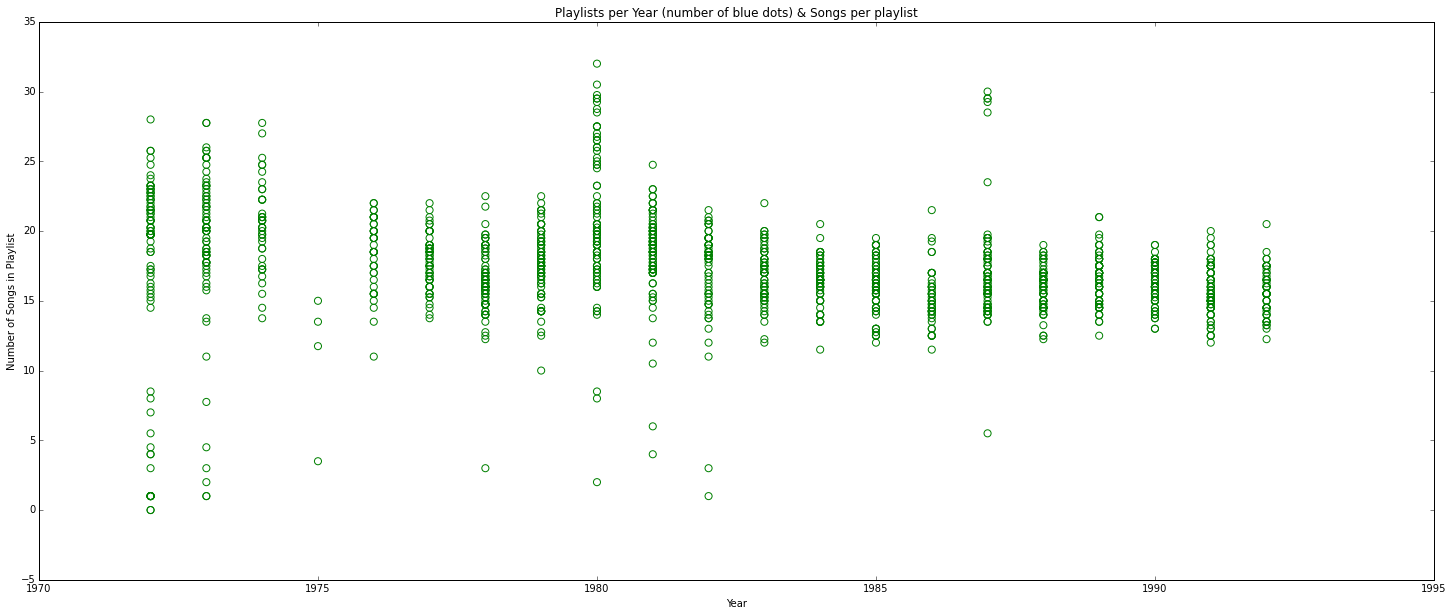

In [46]:
Year = new_df2["year"]
cols = new_df2.columns
dffDF = new_df2[cols[:-1]]
fig = plt.figure(figsize=(25, 10))
ax = plt.subplot(111)
ax.scatter(Year, dffDF.sum(axis = 1), s = 50, edgecolor='green', facecolors = 'none') 
ax.set_title("Playlists per Year (number of blue dots) & Songs per playlist")
ax.set_ylabel("Number of Songs in Playlist")
ax.set_xlabel("Year")

#####Finally let's group by years

In [47]:
def year_grouping(year):
    if year < 1980:
        return "70s"
    elif year >= 1980 and year < 1990:
        return "80s"
    elif year >=1990:
        return "90s"
    else:
        return np.nan

In [48]:
new_df3 = new_df2.copy()

In [49]:
new_df3['year_group'] = new_df3.year.apply(lambda x: year_grouping(x))
new_df3[['year', 'year_group']].head(5)

,year,year_group
0,1987,80s
1,1987,80s
2,1982,80s
3,1990,90s
4,1979,70s


#####By looking at some of the songs here you can see that my simple, quick, easy prediction model is probably not valid
#####Using a 1 with the rest of the vector of zeros is not a good way to predict song to year

In [50]:
new_df3.groupby('year_group').sum()

,all along the watchtower,big river,box of rain,comes time,drums,fire on the mountain,going down the road feeling bad,hell in bucket,here comes sunshine,hey bo diddley,...,who do you love,why dont we do it in the road,wicked messenger,willie and the hand jive,you aint woman enough,you win again,you wont find me,your love at home,set list unknown,year
year_group,,,,,,,,,,,,,,,,,,,,,
70s,0.0,109,19.5,9.5,129.0,33.5,45.0,0.0,17.0,2.0,...,3,0,0,0,14,11,0,1,9,912711
80s,26.0,64,28.5,13.5,356.5,63.5,54.5,77.5,0.0,0.5,...,0,7,1,6,0,0,1,0,1,1432756
90s,20.5,13,13.5,1.5,102.0,16.0,9.0,17.0,1.5,0.5,...,0,0,0,0,0,0,0,0,0,408135
